In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import  train_test_split, cross_val_score, KFold
import optuna
from sklearn.inspection import PartialDependenceDisplay
import shap

import optuna
from functools import partial
import os

## Map breeding stage back into dataframe


In [137]:
mapping_path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'

In [88]:

def load_mapping(path):
    files = os.listdir(path)
    df_original = pd.concat([pd.read_csv(path + '/' + file) for file in files])
    df = df_original.drop(columns=['equinox', 'original_track_id']).reset_index(drop=True)
    return df

In [ ]:
mapping_frame = load_mapping(mapping_path)

In [92]:
print(mapping_frame.head())

   dataset_id     scientific_name     common_name             site_name  \
0         758  Pygoscelis adeliae  Adelie Penguin  South Orkney Islands   
1         758  Pygoscelis adeliae  Adelie Penguin  South Orkney Islands   
2         758  Pygoscelis adeliae  Adelie Penguin  South Orkney Islands   
3         758  Pygoscelis adeliae  Adelie Penguin  South Orkney Islands   
4         758  Pygoscelis adeliae  Adelie Penguin  South Orkney Islands   

            colony_name  lat_colony  lon_colony device bird_id       track_id  \
0  Signy Island/Gourlay      -60.73      -45.59    GPS     826  758_826_11743   
1  Signy Island/Gourlay      -60.73      -45.59    GPS     826  758_826_11743   
2  Signy Island/Gourlay      -60.73      -45.59    GPS     826  758_826_11743   
3  Signy Island/Gourlay      -60.73      -45.59    GPS     826  758_826_11743   
4  Signy Island/Gourlay      -60.73      -45.59    GPS     826  758_826_11743   

     age      sex  breed_stage breed_status    date_gmt  time_

In [94]:
df = pd.read_csv('/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv')
df_base = df.copy()

df_base = df_base.drop(columns=['Unnamed: 0'])


In [132]:
df_adelie = df_base[(df_base['common_name'] == 'Adelie Penguin')].copy()
#df_adelie = pd.get_dummies(df_adelie, columns=['colony_name'])

In [133]:
# Ensure unique track_id values in mapping_frame
mapping_frame_unique = mapping_frame.drop_duplicates(subset='track_id')

# Map breed_stage back to df_adelie from mapping_frame based on track_id
df_adelie['breed_stage'] = df_adelie['track_id'].map(mapping_frame_unique.set_index('track_id')['breed_stage'])
df_adelie['breeed_status'] = df_adelie['track_id'].map(mapping_frame_unique.set_index('track_id')['breed_status'])

In [113]:
df_adelie = pd.get_dummies(df_adelie, columns=['breed_stage', 'breeed_status'])

In [114]:
print(df_adelie.columns)

Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', 'delta

In [124]:


smoothing_window = 7
climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
for var in climate_vars:
    df_adelie[f'{var}_smoothed'] = df_adelie[var].rolling(window=smoothing_window, center=True).mean()

# Drop time-based features and keep only climate variables
needed_vars = ['tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
                'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed', 
                'colony_name_Admiralty Bay', 'colony_name_Hope Bay',
                'colony_name_King George Island',
                'colony_name_Powell Island/Peng colony',
                'colony_name_Signy Island/Gourlay',
                'colony_name_Signy Island/North Point', 
                'breed_stage_brood-guard',
                'breed_stage_chick-rearing', 'breed_stage_creche',
                'breed_stage_incubation', 'breed_stage_non-breeding',
       ]
target = 'km_to_colony_mean'

X = df_adelie[needed_vars]
y = df_adelie[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(df_adelie['track_id'].nunique())

266


### Basic Model Without tuning:

In [125]:
# ----------------------------
# Train Random Forest Model
# ----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# ----------------------------
# Train XGBoost Model
# ----------------------------
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# ----------------------------
# Evaluate Models
# ----------------------------
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R²: {r2:.3f}, RMSE: {rmse:.3f}")

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")


Random Forest - R²: 0.861, RMSE: 101.460
XGBoost - R²: 0.850, RMSE: 105.507


## Random Forest: Bayesian Optimization

In [4]:
def objective_rf(trial):
    """Objective function for Bayesian Optimization of Random Forest."""
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)  # Try n_trials different sets of hyperparameters

# Print best parameters
print(f"Best Random Forest Params: {study_rf.best_params}")
print(f"Best Random Forest R²: {study_rf.best_value:.3f}")

# Train optimized Random Forest
rf_best = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)
rf_best_preds = rf_best.predict(X_test)


evaluate_model(y_test, rf_best_preds, "Random Forest (Bayesian Tuned)")


[I 2025-02-08 14:43:50,011] A new study created in memory with name: no-name-5e963940-4fcd-4a12-a550-d9c4267b4695
[I 2025-02-08 14:43:50,637] Trial 0 finished with value: 0.775943141646323 and parameters: {'n_estimators': 247, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.775943141646323.
[I 2025-02-08 14:43:51,428] Trial 1 finished with value: 0.8394572223375689 and parameters: {'n_estimators': 209, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8394572223375689.
[I 2025-02-08 14:43:52,824] Trial 2 finished with value: 0.8345332068614242 and parameters: {'n_estimators': 389, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8394572223375689.
[I 2025-02-08 14:43:53,879] Trial 3 finished with value: 0.8304909940309522 and parameters: {'n_estimators': 328, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0

Best Random Forest Params: {'n_estimators': 196, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best Random Forest R²: 0.840
Random Forest (Bayesian Tuned) - R²: 0.840, RMSE: 108.963


## XGBoost: Bayesian Optimization

In [5]:
def objective_xgb(trial):
    """Objective function for Bayesian Optimization of XGBoost."""
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)  # Try n_trials different sets of hyperparameters

# Print best parameters
print(f"Best XGBoost Params: {study_xgb.best_params}")
print(f"Best XGBoost R²: {study_xgb.best_value:.3f}")

# Train optimized XGBoost
xgb_best = XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_best.fit(X_train, y_train)
xgb_best_preds = xgb_best.predict(X_test)

evaluate_model(y_test, xgb_best_preds, "XGBoost (Bayesian Tuned)")

[I 2025-02-08 14:44:38,626] A new study created in memory with name: no-name-de46caf4-3dc0-4b04-adb4-630023eeb6f0
[I 2025-02-08 14:44:39,829] Trial 0 finished with value: 0.7969456148926466 and parameters: {'n_estimators': 366, 'learning_rate': 0.15919993294751722, 'max_depth': 10, 'subsample': 0.8255149562738282, 'colsample_bytree': 0.8495684140036706}. Best is trial 0 with value: 0.7969456148926466.
[I 2025-02-08 14:44:40,075] Trial 1 finished with value: 0.8282047695435641 and parameters: {'n_estimators': 206, 'learning_rate': 0.11463857553024787, 'max_depth': 5, 'subsample': 0.6600906468956994, 'colsample_bytree': 0.9163242703598443}. Best is trial 1 with value: 0.8282047695435641.
[I 2025-02-08 14:44:40,897] Trial 2 finished with value: 0.8257682029202353 and parameters: {'n_estimators': 235, 'learning_rate': 0.020086127969082736, 'max_depth': 10, 'subsample': 0.7768111276289181, 'colsample_bytree': 0.6404825136111498}. Best is trial 1 with value: 0.8282047695435641.
[I 2025-02-08

Best XGBoost Params: {'n_estimators': 281, 'learning_rate': 0.05397322781875925, 'max_depth': 8, 'subsample': 0.6815851710244804, 'colsample_bytree': 0.7285256852639725}
Best XGBoost R²: 0.835
XGBoost (Bayesian Tuned) - R²: 0.835, RMSE: 110.545


### Graphs

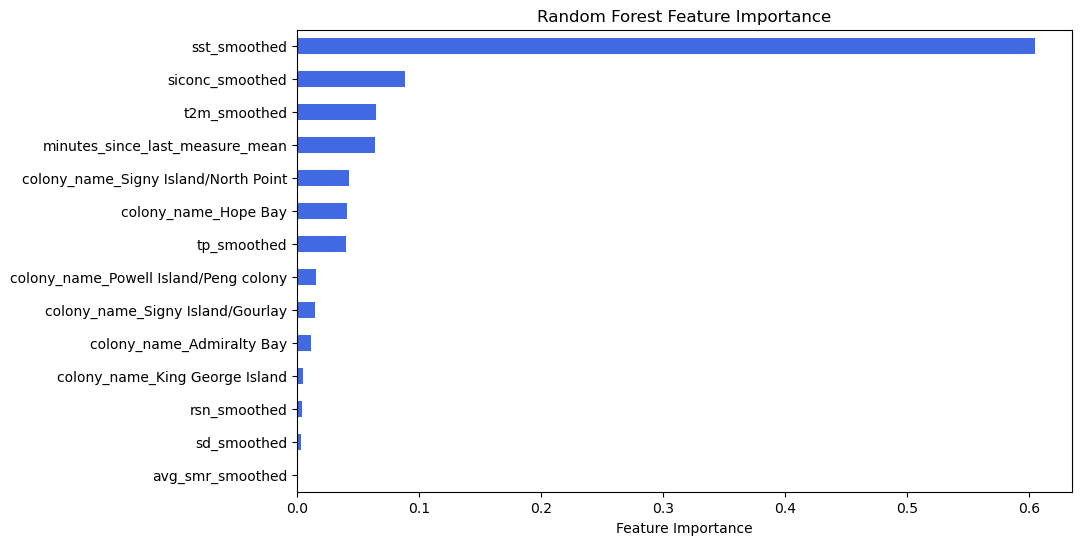

In [6]:
# Get feature importances from RF
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Plot
plt.figure(figsize=(10, 6))
rf_importances.sort_values().plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

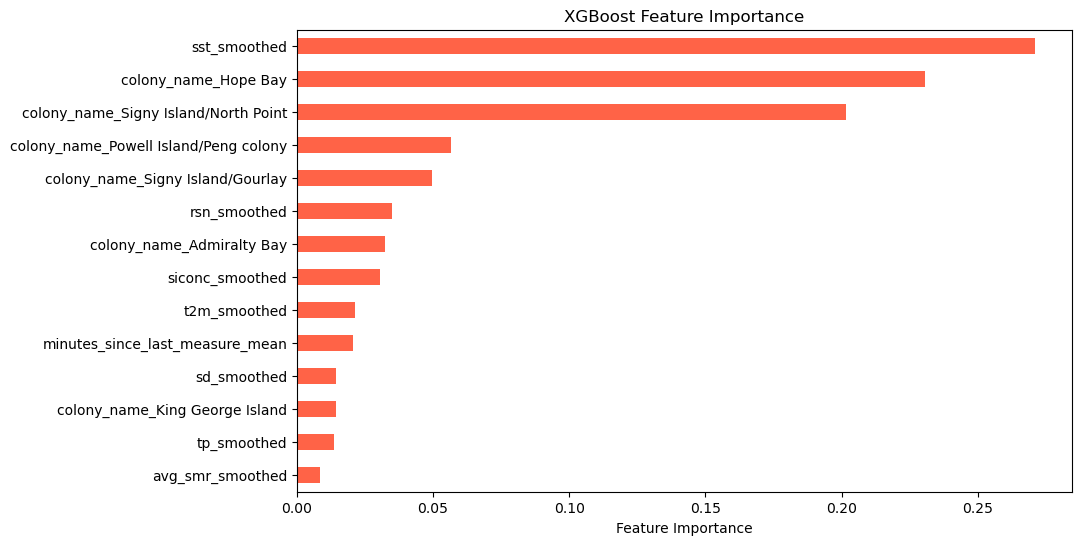

In [7]:
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Plot
plt.figure(figsize=(10, 6))
xgb_importances.sort_values().plot(kind='barh', color='tomato')
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

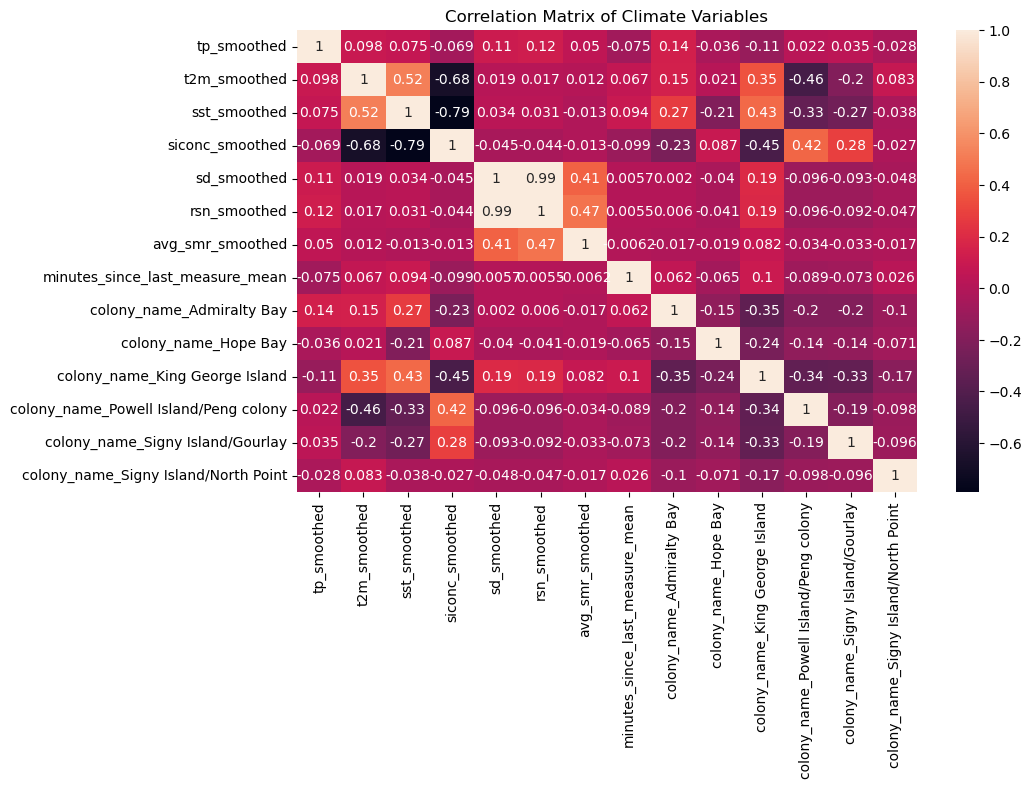

In [12]:
corr = df_adelie[needed_vars].corr()
# save as xlsx
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True)
plt.title(f'Correlation Matrix of Climate Variables')
plt.show()

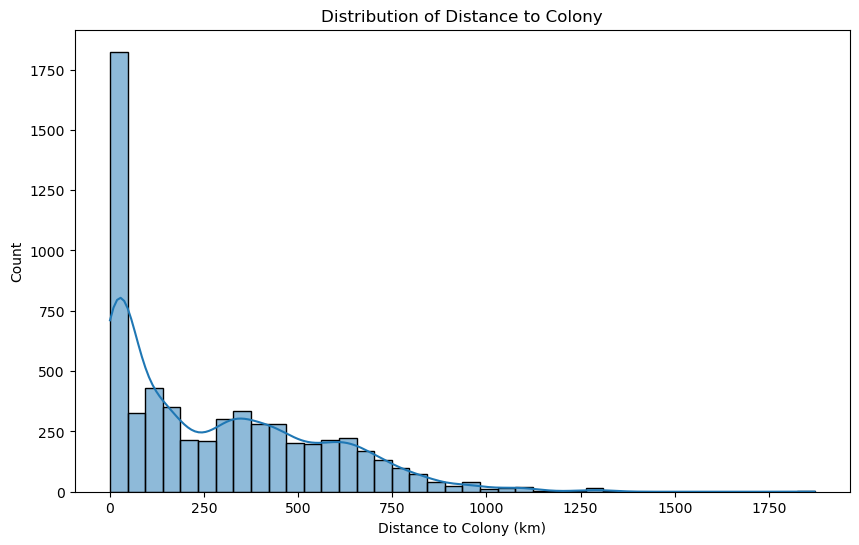

In [ ]:
# plot mean distance to colony
plt.figure(figsize=(10, 6))
sns.histplot(df_adelie['km_to_colony_mean'], kde=True)
plt.title('Distribution of Distance to Colony')
plt.xlabel('Distance to Colony (km)')
plt.show()


In [139]:
def load_mapping(path):
    files = os.listdir(path)
    df_original = pd.concat([pd.read_csv(path + '/' + file) for file in files])
    df = df_original.drop(columns=['equinox', 'original_track_id']).reset_index(drop=True)
    return df

def load_and_preprocess_data(mapping_path, filepath, smoothing_window=7):
    """
    Loads the CSV file, drops unnecessary columns, filters for 'Adelie Penguin',
    creates dummy variables for colony names, and applies a rolling mean
    to specified climate variables.
    """
    # Try to use the first column as index if it contains row identifiers
    try:
        df = pd.read_csv(filepath, index_col=0)
    except Exception as e:
        print("Error loading CSV with index_col=0. Loading without it.")
        df = pd.read_csv(filepath)

    # Remove unwanted column if present
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Filter for 'Adelie Penguin'
    df_adelie = df[df['common_name'] == 'Adelie Penguin'].copy()

    # Load mapping frame
    mapping_frame = load_mapping(mapping_path)
    mapping_frame_unique = mapping_frame.drop_duplicates(subset='track_id')
    
    # map breed_stage back to df_adelie from mapping_frame based on track_id
    df_adelie['breed_stage'] = df_adelie['track_id'].map(mapping_frame_unique.set_index('track_id')['breed_stage'])

    # Create dummy variables for 'colony_name'
    df_adelie = pd.get_dummies(df_adelie, columns=['colony_name'])
    df_adelie = pd.get_dummies(df_adelie, columns=['breed_stage'])

    # List of climate variables to smooth
    climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
    for var in climate_vars:
        smoothed_var = f'{var}_smoothed'
        df_adelie[smoothed_var] = df_adelie[var].rolling(window=smoothing_window, center=True).mean()

    # Drop rows with NaNs resulting from rolling mean at the boundaries
    smoothed_cols = [f'{var}_smoothed' for var in climate_vars]
    df_adelie.dropna(subset=smoothed_cols, inplace=True)

    return df_adelie


def get_features_and_target(df_adelie):
    """
    Constructs the feature matrix X and the target vector y.
    Dynamically collects dummy columns for colony names.
    """
    # Define the climate feature columns (smoothed values)
    needed_vars = [
                'tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
                'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed', 
                'colony_name_Admiralty Bay', 'colony_name_Hope Bay',
                'colony_name_King George Island',
                'colony_name_Powell Island/Peng colony',
                'colony_name_Signy Island/Gourlay',
                'colony_name_Signy Island/North Point', 
                'breed_stage_brood-guard',
                'breed_stage_chick-rearing', 'breed_stage_creche',
                'breed_stage_incubation', 'breed_stage_non-breeding',
    ]

    target = 'km_to_colony_mean'
    X = df_adelie[needed_vars]
    y = df_adelie[target]

    return X, y


def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates the predictions using R² and RMSE.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R²: {r2:.3f}, RMSE: {rmse:.3f}")
    return r2, rmse


def baseline_models(X_train, X_test, y_train, y_test):
    """
    Trains baseline Random Forest and XGBoost models and evaluates their performance.
    """
    # Train baseline Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    evaluate_model(y_test, rf_preds, "Random Forest")

    # Train baseline XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    evaluate_model(y_test, xgb_preds, "XGBoost")

    return rf_model, xgb_model


def objective_rf(trial, X, y):
    """
    Objective function for optimizing Random Forest hyperparameters using cross-validation.
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    return scores.mean()


def objective_xgb(trial, X, y):
    """
    Objective function for optimizing XGBoost hyperparameters using cross-validation.
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    return scores.mean()


def hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for both Random Forest and XGBoost using Optuna
    and returns the best models trained on the training set.
    """
    # Optimize Random Forest hyperparameters
    study_rf = optuna.create_study(direction="maximize")
    study_rf.optimize(partial(objective_rf, X=X_train, y=y_train), n_trials=50)
    print(f"Best Random Forest Params: {study_rf.best_params}")
    print(f"Best Random Forest CV R²: {study_rf.best_value:.3f}")

    rf_best = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
    rf_best.fit(X_train, y_train)

    # Optimize XGBoost hyperparameters
    study_xgb = optuna.create_study(direction="maximize")
    study_xgb.optimize(partial(objective_xgb, X=X_train, y=y_train), n_trials=50)
    print(f"Best XGBoost Params: {study_xgb.best_params}")
    print(f"Best XGBoost CV R²: {study_xgb.best_value:.3f}")

    xgb_best = XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1, verbosity=0)
    xgb_best.fit(X_train, y_train)

    return rf_best, xgb_best


def main():
    # File path to the CSV file (adjust as needed)
    filepath = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv'

    # Load and preprocess the data
    df_adelie = load_and_preprocess_data(mapping_path , filepath, smoothing_window=7)
    X, y = get_features_and_target(df_adelie)

    # Perform an 80/20 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("=== Baseline Model Performance on Test Set ===")
    baseline_models(X_train, X_test, y_train, y_test)

    print("\n=== Hyperparameter Tuning (Using 5-Fold CV on Training Set) ===")
    rf_best, xgb_best = hyperparameter_tuning(X_train, y_train)

    print("\n=== Optimized Model Performance on Test Set ===")
    # Evaluate optimized Random Forest
    rf_best_preds = rf_best.predict(X_test)
    evaluate_model(y_test, rf_best_preds, "Random Forest (Optimized)")

    # Evaluate optimized XGBoost
    xgb_best_preds = xgb_best.predict(X_test)
    evaluate_model(y_test, xgb_best_preds, "XGBoost (Optimized)")


if __name__ == '__main__':
    main()

=== Baseline Model Performance on Test Set ===
Random Forest - R²: 0.872, RMSE: 96.502


[I 2025-02-08 18:40:05,866] A new study created in memory with name: no-name-3f33a170-aff3-43c3-a537-cc9825b0d0a4


XGBoost - R²: 0.861, RMSE: 100.569

=== Hyperparameter Tuning (Using 5-Fold CV on Training Set) ===


[I 2025-02-08 18:40:11,608] Trial 0 finished with value: 0.8897377200581417 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8897377200581417.
[I 2025-02-08 18:40:15,525] Trial 1 finished with value: 0.9027702444872207 and parameters: {'n_estimators': 253, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9027702444872207.
[I 2025-02-08 18:40:18,586] Trial 2 finished with value: 0.8822691198699035 and parameters: {'n_estimators': 236, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9027702444872207.
[I 2025-02-08 18:40:24,163] Trial 3 finished with value: 0.9012311923442979 and parameters: {'n_estimators': 405, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9027702444872207.
[I 2025-02-08 18:40:25,288] Trial 4 finished with value: 0.8676202730270189 and parameters: 

Best Random Forest Params: {'n_estimators': 415, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Random Forest CV R²: 0.908


[I 2025-02-08 18:44:15,624] A new study created in memory with name: no-name-693ae8a9-19c0-45bb-8964-33e6237b2320
[I 2025-02-08 18:44:16,322] Trial 0 finished with value: 0.8369977167737709 and parameters: {'n_estimators': 460, 'learning_rate': 0.011218991305430812, 'max_depth': 4, 'subsample': 0.7694598175091633, 'colsample_bytree': 0.602117522434092}. Best is trial 0 with value: 0.8369977167737709.
[I 2025-02-08 18:44:17,286] Trial 1 finished with value: 0.8963588913773555 and parameters: {'n_estimators': 211, 'learning_rate': 0.14516035369819497, 'max_depth': 8, 'subsample': 0.6328721438937059, 'colsample_bytree': 0.7158380791430646}. Best is trial 1 with value: 0.8963588913773555.
[I 2025-02-08 18:44:18,432] Trial 2 finished with value: 0.8776749679684851 and parameters: {'n_estimators': 128, 'learning_rate': 0.016772161862074586, 'max_depth': 10, 'subsample': 0.8234633039204158, 'colsample_bytree': 0.8642719245199035}. Best is trial 1 with value: 0.8963588913773555.
[I 2025-02-08 

Best XGBoost Params: {'n_estimators': 479, 'learning_rate': 0.030525382469080983, 'max_depth': 10, 'subsample': 0.7862182791643624, 'colsample_bytree': 0.9817015077596027}
Best XGBoost CV R²: 0.912

=== Optimized Model Performance on Test Set ===
Random Forest (Optimized) - R²: 0.873, RMSE: 95.960
XGBoost (Optimized) - R²: 0.881, RMSE: 93.121


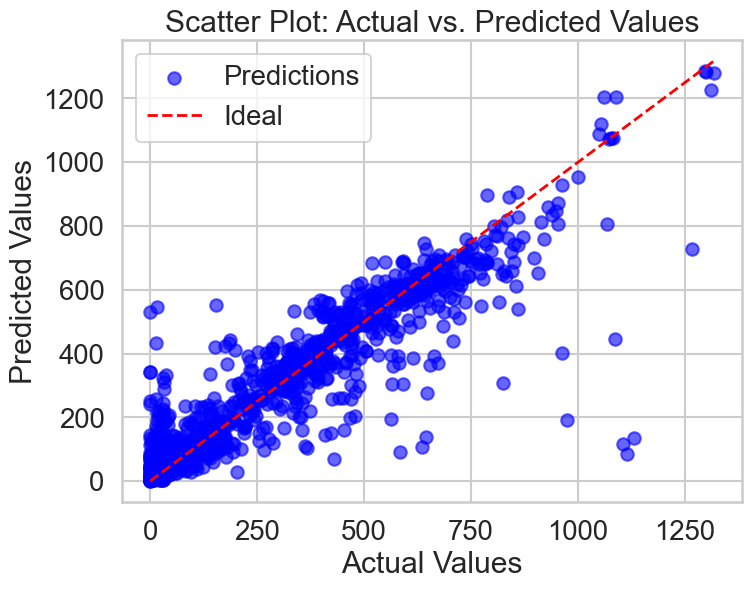

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_best_preds, color='blue', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2, linestyle='--', label='Ideal')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: Actual vs. Predicted Values")
plt.legend()
plt.show()

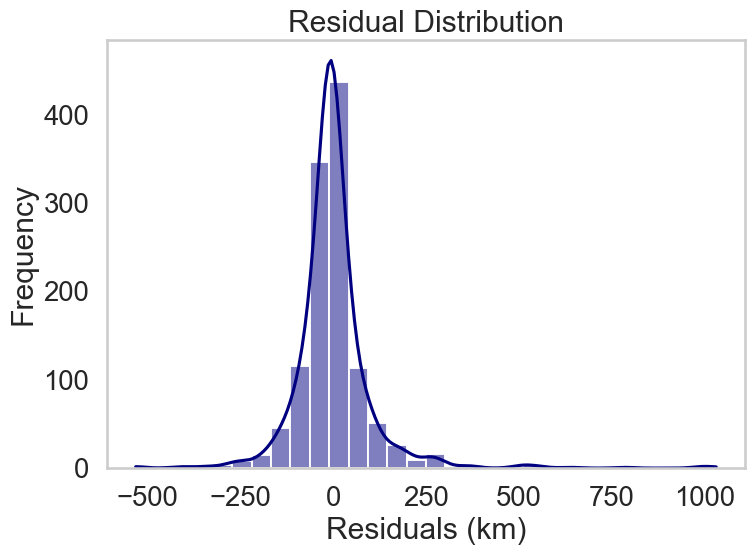

In [141]:

residuals = y_test - rf_best_preds
plt.figure(figsize=(8, 6))

# Plot a histogram with a KDE overlay for the residuals
sns.histplot(residuals, bins=30, kde=True, color='navy')

plt.xlabel("Residuals (km)")
plt.ylabel("Frequency")
plt.grid(False)
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

Track_ID and minutes since last measure mean are not important, since they are assumed to not have a relationship (penguins are assumed IID)


In [45]:
# print all dates that have more than 1 value
print(df_adelie['date_gmt'].value_counts().loc[lambda x: x > 1])


2016-12-12    46
2017-02-06    44
2017-02-07    43
2016-11-19    42
2016-11-20    42
              ..
2013-05-10     2
2013-01-10     2
2002-02-22     2
2002-02-20     2
2002-02-21     2
Name: date_gmt, Length: 736, dtype: int64
